In [1]:
#import kaggle
import numpy as np
import pandas as pd
import matplotlib as plt
from sqlalchemy import create_engine
import zipfile
import sqlite3
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
import math;

In [2]:

Switch=True

SunFlareDataSet='hessi.solar.flare.2002to2016.csv'

db_file_path = 'SunFlareDatabase.db'
table_name="SunFlareData"

conn= sqlite3.connect(db_file_path)

df = pd.read_csv(SunFlareDataSet)
df.to_sql(table_name, conn, if_exists='replace', index=False)
read_df = pd.read_sql(f'SELECT * FROM {table_name} LIMIT 5', conn)
read_df.head()


,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,None,None,None
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,None
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,None,None,None
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,None,None,None
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2


In [3]:
df.describe()
df.columns

Index(['flare', 'start.date', 'start.time', 'peak', 'end', 'duration.s',
       'peak.c/s', 'total.counts', 'energy.kev', 'x.pos.asec', 'y.pos.asec',
       'radial', 'active.region.ar', 'flag.1', 'flag.2', 'flag.3', 'flag.4',
       'flag.5'],
      dtype='object')

Data acquisition - describe in some detail the dataset(s) you intend to work with. 
What data elements exist, how are they structured, what features you hope to extract, etc. 
This is also the place to explain where the data came from, and any limitations on your use/sharing of the data or your work on the data.

The data I am working with, is Sun Flare data, which is from the kaggle database website, and from the database provided by the class underthe physics section. The data is structured, by date, and then goes into detail about start, peak and end times, with a duration of the data. The describes the amount of energy released, its x and y position and radial position according to earth's perspective. The data also has up to 5 flags, flag 1: is the attenuator state. flag 2: mostly GD - Data gap during flare, and the Pn - Position Quality 0-1. flag 3: PE- Particle event: Particles are present or Pn. flag 4 describes the Qn - Data Quality: Q0 = Highest Quality, Q11 = Lowest Quality, and PE. Flag 5 describes the SE - Flare ended when spacecraft was in SAA and the Qn - Data Quality. The flags, duration, energy, and are the data points I wish to investigate, more spefically, I am interested in the eclipse events because when an eclipse ocurrins a satellite gains no energy and therefore the back up battery turns on. I can run calculations, with some of this data.

Here are all of the Flags down below. 

a0 - In attenuator state 0 (None) sometime during flare

a1 - In attenuator state 1 (Thin) sometime during flare

a2 - In attenuator state 2 (Thick) sometime during flare

a3 - In attenuator state 3 (Both) sometime during flare

An - Attenuator state (0=None, 1=Thin, 2=Thick, 3=Both) at peak of flare

DF - Front segment counts were decimated sometime during flare

DR - Rear segment counts were decimated sometime during flare

ED - Spacecraft eclipse (night) sometime during flare

EE - Flare ended in spacecraft eclipse (night)

ES - Flare started in spacecraft eclipse (night)

FE - Flare ongoing at end of file

FR - In Fast Rate Mode

FS - Flare ongoing at start of file

GD - Data gap during flare

GE - Flare ended in data gap

GS - Flare started in data gap

MR - Spacecraft in high-latitude zone during flare

NS - Non-solar event

PE - Particle event: Particles are present

PS - Possible Solar Flare; in front detectors, but no position

Pn - Position Quality: P0 = Position is NOT valid, P1 = Position is valid

Qn - Data Quality: Q0 = Highest Quality, Q11 = Lowest Quality

SD - Spacecraft was in SAA sometime during flare

SE - Flare ended when spacecraft was in SAA

SS - Flare started when spacecraft was in SAA"""

#Preprocessing - this section includes your findings from initial data cleansing, exploratory statistics and visualizations, and additional information on reduced features selected through dimensionality reduction (if appropriate).



In [4]:
class SolarArray:
    def __init__(self):
        self.Xe= .6 #Efficiency during Eclipse
        self.Xd= .8 #Efficiency during Daylight 
        self.Po=.30*1368 #W/m^2 Power output with sun normal to surface of cells
        self.Id= .77 #Inherent Degration
        self.D = .05 #Degration per year
        self.L= 3 #satellite lifetime in years, the mission lasted 16 years
    def Psa(self, Pd, td, Pe, te): #Power the solar array provided during sunlight.
        return (((Pd*td)/self.Xd) + ((Pe*te)/self.Xe))/(td)
    def PBOL(self, theta): #Power beginning of life 
        return self.Po*self.Id*math.cos(math.radians(theta))
    def Ld(self): #Life Degration
        return(1-self.D)**self.L
    def PEOL(self,theta): #Power Beginning of Life
        return self.PBOL(theta)*self.Ld()  
    def Asa(self,Pd, td, Pe, te,theta): #Solar Array area
        return self.Psa(Pd, td, Pe, te)*self.PEOL(theta)



In [5]:
class Battery:
    def __init__(self):
        self.SimulateSolarArray=SolarArray() #
        self.nbat= .95 # Battery to load transmit efficiency
        self.DOD= .5 #Depth of Discharge
        self.Nyears=self.SimulateSolarArray.L # Length of mission
        self.Ffading= .007 #Degradation per Year
        self.mspec= 140 #Specifc Mass (Wh/kg)
        self.eDensity=300 #Energy Density of Battery (Wh/Liter)

    def Creq(self, Pe, Te): #Capacity Requirement
        return Pe*Te 
    def CEOL(self, Pe, Te): #Capacity End of Life
        return self. Creq(Pe, Te)/(self.nbat*self.DOD)
    def CBOL(self,Pe, Te): # Capacity Beginning of Life
        return self.CEOL(Pe, Te)/(1-(self.Ffading*self.Nyears))
    def Mbat(self,Pe, Te): # Mass  of Battery
        return self.CBOL(Pe, Te)/self.mspec
    def Vbat(self,Pe, Te): # Volume of Battery
        return self.CBOL(Pe, Te)/self.eDensity

In [14]:
class Telemetry:
    def __init__(self):
        
        self.TransmitAntennaGain = None
        self.UpEIRP = None
        self.Range = None
        self.FreeSpaceLoss = None
        self.TotalPathLossFunc = None
        self.RecievertAntennaGain= None
        self.GT=None
        self.CombinedLoss=None
        self.DownEIRP=None
        self.RecieverCarrierToNoise=None
        self.AvailaibleLink=None
    
    def AntennaGainFunc(UplinkFrequency, Diameter, TransmitEfficieny):
        self.AntennaGain=20.4+20*math.log(UplinkFrequency)+20*math.log(Diameter)+10*math.log(TransmitEfficieny)
        return self.AntennaGain
    def UpEIRPFunc(TransmitPower, L):
        self.UpEIRP=18*math.log(TransmitPower)+ self.TransmitAntennaGain-L
        return self.UpEIRP
    def RangeFunc(RangeElevation, height, Alpha):
        self.Range = math.sqrt((RangeElevation+height)**2-(RangeElevation*math.cos(math.radiains(Alpha)))**2-RangeElevation*sin(Alpha))
        return self.Range
    def FreeSpaceLossFunc():
        self.FreeSpaceLoss=92.45+ 20* math.log(self.Range)
        return self.FreeSpaceLoss
        
    def TotalPathLossFunc(AtmosphericLoss):
        self.TotalPathLoss=self.FreeSpaceLoss+ AtmosphericLoss
        return self.TotalPathLoss
        
    def RecievertAntennaGainFunc(DownlinkFrequency, Diameter, TransmitEfficiency):
        self.RecievertAntennaGain=20.4+20*math.log(UplinkFrequency)+20*math.log(Diameter)+10*math.log(TransmitEfficieny)
        return self.RecievertAntennaGain
        
    def GTFunc(TemperatureSystemNoise):
        self.GT=self.RecievertAntennaGain-10*math.log(TemperatureSystemNoise)
        return  self.GT
        
    def CombinedLossFunc(LinLossOnSatellite):
        self.CombinedLossFunc=self.FreeSpaceLoss+ LinLossOnSatellite
        return self.CombinedLossFunc
        
    def DownEIRPFunc(TransmitPower, L):
        self.DownEIRP=18*math.log(TransmitPower)+ self.RecievertAntennaGainFunc-L 
        return self.DownEIRP
    def RecieverCarrierToNoiseFunc():
        self.RecieverCarrierToNoiseFunc=228.6+self.DownEIRP+self.GT-self.CombinedLoss
        return self.RecieverCarrierToNoiseFunc
    
    def AvailaibleLinkFunc(BitsPerSecond):
        self.AvailaibleLink=self.RecieverCarrierToNoise - 10*math.log(BitsPerSecond)
        return self.AvailaibleLink

In [8]:
import pandas as pd
import sqlite3

# Set switch and file paths
Switch = True
SunFlareDataSet= "hessi.solar.flare.2002to2016.csv"

# Database file path and table name
db_file_path = 'SunFlareDatabase.db'
table_name = "SunFlareData"

# Load the CSV data into a DataFrame
df = pd.read_csv(SunFlareDataSet)
df=df[:101900]

# Define the function to create the Battery table
def CreateBattery():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Battery (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date REAL,
        Orbit REAL,
        PowerEclipse REAL,
        DurationEclipse REAL,
        CapacityRequirement REAL,
        CapacityEndOfLife REAL,
        CapacityBeginningOfLife REAL,
        BatteryMass REAL,
        BatteryVolume REAL,
        XCoordinate_AU REAL, 
        YCoordinate_AU REAL  
    )
    ''')
    conn.commit()
    conn.close()

In [9]:
# Define the function to create the SolarArray table
def CreateSolarArray():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS SolarArray (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date REAL,
        Orbit REAL,
        PowerDaylight REAL,
        DurationDaylight REAL,
        PowerEclipse REAL,
        DurationEclipse REAL,
        PowerSolarArray REAL,
        PowerOutput REAL,
        PowerBeginningOfLife REAL,
        LifeDegradation REAL,
        PowerEndOfLife REAL,
        SolarArrayArea REAL,
        XCoordinate_AU REAL, 
        YCoordinate_AU REAL 
    )
    ''')
    conn.commit()
    conn.close()

In [10]:
def CreateTelemetryUplink():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TelemetryUplink (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date REAL,
        Orbit REAL,
        TransmitAntennaGain REAL,
        EquivalentIsotroficRadiativePower REAL,
        Range REAL,
        FreeSpaceLoss REAL,
        TotalPathLoss REAL,
        RecieverAtennaGain REAL,
        GainToNoiseTemperature REAL,
        CombinedLoss REAL,
        RecieverCarrierToNoise REAL,
        AvailaibleUpLink REAL,
    )
    ''')
    conn.commit()
    conn.close()

In [11]:
def CreateTelemetryDownlink():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TelemetryUlink (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date REAL,
        Orbit REAL,
        TransmitAntennaGain REAL,
        EquivalentIsotroficRadiativePower REAL,
        Range REAL,
        FreeSpaceLoss REAL,
        TotalPathLoss REAL,
        RecieverAtennaGain REAL,
        GainToNoiseTemperature REAL,
        CombinedLoss REAL,
        RecieverCarrierToNoise REAL,
        AvailaibleUpLink REAL,
    )
    ''')
    conn.commit()
    conn.close()

In [12]:
def CreateMarginLinkCheatSheet():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TelemetryDownlink (
        Modulation REAL PRIMARY KEY AUTOINCREMENT,
        Bits/Symbol REAL,
        CodeRate REAL,
        SpectralEfficieny REAL,
        BitEnergyToNoise REAL,
    )
    ''')
    conn.commit()
    conn.close()

In [ ]:
def CreateTelemetryMarginLink():
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS TelemetryUlink (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        FOREIGN KEY (BitEnergyToNoiseUpLink) REFERENCES (TelemetryUplink),
        FOREIGN KEY (BitEnergyToNoiseDownLink) REFERENCES (TelemetryDownlink),
        Modulation REAL  KEY,
        CombinedBitEnergyToNoise REAL,
        
        
        Date REAL,
        Orbit REAL,
    )
    ''')
    conn.commit()
    conn.close()

In [16]:
# Insert data function
def InsertSolarData(Pd, Pe, td, te, endDate, orbitCounter, X, Y):
    SimulateSolarArray = SolarArray()
    PowerSolarArray = SimulateSolarArray.Psa(Pd, td, Pe, te)
    PowerOutput = SimulateSolarArray.Psa(Pd, td, Pe, te)
    PowerBeginningOfLife = SimulateSolarArray.PBOL(23.5)
    LifeDegradation = SimulateSolarArray.Ld()
    PowerEndOfLife = SimulateSolarArray.PEOL(23.5)
    SolarArrayArea = SimulateSolarArray.Asa(Pd, td, Pe, te, 23.5)
    if Pe!=0:
        Pconstant=81
    else:
        Pconstant=0
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    INSERT INTO SolarArray (
        Date, Orbit, PowerDaylight, DurationDaylight, PowerEclipse, DurationEclipse, PowerSolarArray, PowerOutput,
        PowerBeginningOfLife, LifeDegradation, PowerEndOfLife, SolarArrayArea, XCoordinate_AU, YCoordinate_AU
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (endDate, orbitCounter, 4*Pd, td, 4*Pe, te, PowerSolarArray, PowerOutput, PowerBeginningOfLife, LifeDegradation, PowerEndOfLife, SolarArrayArea, X, Y))
    conn.commit()
    conn.close()

In [17]:
def InsertBatteryData(Pe, te, endDate, orbitCounter, X, Y):
    SimulateBattery = Battery()
    CapacityRequirement = SimulateBattery.Creq(Pe, te)
    CapacityEndOfLife = SimulateBattery.CEOL(Pe, te)
    CapacityBeginningOfLife = SimulateBattery.CBOL(Pe, te)
    BatteryMass = SimulateBattery.Mbat(Pe, te)
    BatteryVolume = SimulateBattery.Vbat(Pe, te)
    
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    
    cursor.execute('''
        INSERT INTO Battery (
            Date, Orbit, PowerEclipse, DurationEclipse, CapacityRequirement, CapacityEndOfLife, 
            CapacityBeginningOfLife, BatteryMass, BatteryVolume, XCoordinate_AU, YCoordinate_AU
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (endDate, orbitCounter, 4*Pe, te, CapacityRequirement, CapacityEndOfLife, CapacityBeginningOfLife, BatteryMass, BatteryVolume, X, Y))
    
    conn.commit()
    conn.close()

In [18]:
def InsertSolarData(Pd, Pe, td, te, endDate, orbitCounter, X, Y):
    SimulateSolarArray = SolarArray()
    PowerSolarArray = SimulateSolarArray.Psa(Pd, td, Pe, te)
    PowerOutput = SimulateSolarArray.Psa(Pd, td, Pe, te)
    PowerBeginningOfLife = SimulateSolarArray.PBOL(23.5)
    LifeDegradation = SimulateSolarArray.Ld()
    PowerEndOfLife = SimulateSolarArray.PEOL(23.5)
    SolarArrayArea = SimulateSolarArray.Asa(Pd, td, Pe, te, 23.5)
    if Pe!=0:
        Pconstant=81
    else:
        Pconstant=0
    conn = sqlite3.connect('SunFlareDatabase.db')
    cursor = conn.cursor()
    cursor.execute('''
    INSERT INTO SolarArray (
        Date, Orbit, PowerDaylight, DurationDaylight, PowerEclipse, DurationEclipse, PowerSolarArray, PowerOutput,
        PowerBeginningOfLife, LifeDegradation, PowerEndOfLife, SolarArrayArea, XCoordinate_AU, YCoordinate_AU
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (endDate, orbitCounter, 4*Pd, td, 4*Pe, te, PowerSolarArray, PowerOutput, PowerBeginningOfLife, LifeDegradation, PowerEndOfLife, SolarArrayArea, X, Y))
    conn.commit()
    conn.close()

In [13]:
class UplinkData:
    def __init__(self, uplink_frequency, diameter, transmit_efficiency, transmit_power, L):
        self.uplink_frequency = uplink_frequency
        self.diameter = diameter
        self.transmit_efficiency = transmit_efficiency
        self.transmit_power = transmit_power
        self.L = L

class DownlinkData:
    def __init__(self, downlink_frequency, diameter, transmit_efficiency, lin_loss_on_satellite, transmit_power, L):
        self.downlink_frequency = downlink_frequency
        self.diameter = diameter
        self.transmit_efficiency = transmit_efficiency
        self.lin_loss_on_satellite = lin_loss_on_satellite
        self.transmit_power = transmit_power
        self.L = L
]
def InsertTelemetryDataSheet(UpinkData,DownLinkData):
    LinkSheet=[UpinkData,DownLinkData]
    for Direction in range(2):
        LinkSheet[Direction]=Telemetry()
        LinkSheet[Direction]=.AntennaGainFunc(UplinkFrequency, Diameter, TransmitEfficieny)
        LinkSheet[Direction]=.UpEIRPFunc(TransmitPower, L)
        LinkSheet[Direction]=.RangeFunc(RangeElevation, height, Alpha)
        LinkSheet[Direction]=.FreeSpaceLossFunc()
        LinkSheet[Direction]=.TotalPathLossFunc(AtmosphericLoss)
        LinkSheet[Direction]=.RecievertAntennaGainFunc(DownlinkFrequency, Diameter, TransmitEfficiency)
        LinkSheet[Direction]=.GTFunc(TemperatureSystemNoise)
        LinkSheet[Direction]=.CombinedLossFunc(LinLossOnSatellite)
        LinkSheet[Direction]=.DownEIRPFunc(TransmitPower, L)
        LinkSheet[Direction]=.RecieverCarrierToNoiseFunc()
        LinkSheet[Direction]=.AvailaibleLinkFunc(BitsPerSecond)
        conn = sqlite3.connect('SunFlareDatabase.db')
        cursor = conn.cursor()
        cursor.execute('''
        INSERT INTO TelemetryUplink (
            Date, Orbit, TransmitAntennaGain, EquivalentIsotroficRadiativePower, Range, FreeSpaceLoss, TotalPathLoss, RecieverAtennaGain,
        GainToNoiseTemperature, CombinedLoss, RecieverCarrierToNoise, AvailaibleUpLink
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (endDate, orbitCounter, 4*Pd, td, 4*Pe, te, PowerSolarArray, PowerOutput, PowerBeginningOfLife, LifeDegradation, PowerEndOfLife, SolarArrayArea, X, Y))
# Drop existing tables and create new ones
"""TelemetryUplink (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date REAL,
        Orbit REAL,
        TransmitAntennaGain REAL,
        EquivalentIsotroficRadiativePower REAL,
        Range REAL,
        FreeSpaceLoss REAL,
        TotalPathLoss REAL,
        RecieverAtennaGain REAL,
        GainToNoiseTemperature REAL,
        CombinedLoss REAL,
        RecieverCarrierToNoise REAL,
        AvailaibleUpLink REAL,"""




conn = sqlite3.connect('SunFlareDatabase.db')
conn.execute("DROP TABLE IF EXISTS SolarArray")
conn.execute("DROP TABLE IF EXISTS Battery")
conn.close()

In [ ]:
InsertMarginLinkCheatSheet(Combined)

In [ ]:
CreateBattery()
CreateSolarArray()

In [6]:

# Connect to the SQLite database
conn = sqlite3.connect(db_file_path)

# Write the DataFrame to an SQLite table
df.to_sql(table_name, conn, if_exists='replace', index=False)

# Verify the data loaded into the table
read_df = pd.read_sql(f'SELECT * FROM {table_name} LIMIT 5', conn)
print(read_df.head())

# Extract the 'energy.kev' column
energy_df = pd.read_sql(f'SELECT "energy.kev" FROM {table_name}', conn)
keV_to_Watt_factor = 1.60218e-16  # Example: 1 keV = 1.60218e-16 Joules
energyList = energy_df["energy.kev"].tolist()
WattsList = []

for keV in energyList:
    try:
        base, exponent = map(int, keV.split("-"))
        value = base ** (-exponent) * keV_to_Watt_factor
        WattsList.append(value)
    except Exception as e:
        print(f"Error processing keV value '{keV}': {e}")
        WattsList.append(None)

# Update the database table with the new Watts values
conn.execute('ALTER TABLE SunFlareData ADD COLUMN "Watts" REAL')

for i, value in enumerate(WattsList):
    conn.execute(f'UPDATE SunFlareData SET "Watts" = ? WHERE rowid = ?', (value, i + 1))

# Verify the updated data
read_df = pd.read_sql(f'SELECT * FROM {table_name}', conn)
print(read_df.head())

# Check for the presence of None or NaN values in each column
print("\nChecking for None or NaN values in each column:")
print(read_df.isnull().sum())

# Identify the columns with the highest percentage of missing values
missing_data_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values in each column:")
print(missing_data_percentage.sort_values(ascending=False))

# Close and reopen the connection to refresh changes
conn.close()

     flare  start.date start.time      peak       end  duration.s  peak.c/s  \
0  2021213  2002-02-12   21:29:56  21:33:38  21:41:48         712       136   
1  2021228  2002-02-12   21:44:08  21:45:06  21:48:56         288         7   
2  2021332  2002-02-13   00:53:24  00:54:54  00:57:00         216        15   
3  2021308  2002-02-13   04:22:52  04:23:50  04:26:56         244        20   
4  2021310  2002-02-13   07:03:52  07:05:14  07:07:48         236       336   

   total.counts energy.kev  x.pos.asec  y.pos.asec  radial  active.region.ar  \
0        167304      12-25         592        -358     692                 0   
1          9504       6-12         604        -341     694              9811   
2         11448       6-12        -310         375     487              9825   
3         17400      12-25        -277         378     469              9822   
4        313392      25-50        -272         390     476              9825   

  flag.1 flag.2 flag.3 flag.4 flag.5  
0    

In [7]:
#####Let the algorithm run for like 2-5 minutes and then run the next tab to see the data. #####
##### If you see errors reload the page and then run it again, the database will lockup sometimes,
##### becasue the program believes it is in another process is still on.
conn = sqlite3.connect(db_file_path)

# Define the columns where you want to search for the flags
flag_columns = ['flag.2', 'flag.3', 'flag.4', 'flag.5']

# Process the dataset
df = pd.read_sql(f'SELECT * FROM {table_name}', conn)
df = df[:101900]

Pd = Pe = td = te = 0
OrbitPeriod = 96.50 * 60
orbitCounter = 0

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    if te + td >= OrbitPeriod:
        orbitCounter += 1
        endDate = row['start.date']
        if orbitCounter > 15:
            orbitCounter = 0
        if td != 0:  # Ensure td and te are not zero
            InsertSolarData(Pd, Pe, td, te, endDate, orbitCounter, X, Y)
        if te != 0 and Pe != 0:  # Ensure td and te are not zero
            InsertBatteryData(Pe, te, endDate, orbitCounter, X, Y)
        te = Pe = Pd = td = 0  # Reset variables for the new date

    if any(row[column] == 'ES' for column in flag_columns):
        te += row['duration.s']
        Pe += WattsList[index] if WattsList[index] is not None else 0  # Handle None values
    elif any(row[column] == 'EE' for column in flag_columns):
        te += row['duration.s']
        Pe += WattsList[index] if WattsList[index] is not None else 0  # Handle None values
    elif any(row[column] == 'ED' for column in flag_columns):
        te += row['duration.s']
        Pe += WattsList[index] if WattsList[index] is not None else 0  # Handle None values
    elif any(row[column] == 'P1' and row[column] not in ['EE', 'ED', 'ES'] for column in flag_columns):
        td += row['duration.s']
        Pd += WattsList[index] if WattsList[index] is not None else 0  # Handle None values

    endDate = row['start.date']
    X = row['x.pos.asec']
    Y = row['y.pos.asec']
    
# Insert data for the last set of values
if td != 0:  # Ensure td and te are not zero
    InsertSolarData(Pd, Pe, td, te, endDate, orbitCounter, X, Y)
if te != 0 and Pe != 0:  # Ensure td and te are not zero
    InsertBatteryData(Pe, te, endDate, orbitCounter, X, Y)


In [8]:
processed_df = pd.read_sql(f'SELECT * FROM SolarArray', conn)
print(processed_df.head())
processed_df = pd.read_sql(f'SELECT * FROM Battery', conn)
print(processed_df.head())






   id        Date  Orbit  PowerDaylight  DurationDaylight  PowerEclipse  \
0   1  2002-02-14    1.0   1.177650e-24            6100.0           0.0   
1   2  2002-02-17    2.0   2.649713e-24            5952.0           0.0   
2   3  2002-02-18    3.0   2.060888e-24            6980.0           0.0   
3   4  2002-02-18    4.0   3.238538e-24            8792.0           0.0   
4   5  2002-02-19    5.0   2.944125e-24            5820.0           0.0   

   DurationEclipse  PowerSolarArray   PowerOutput  PowerBeginningOfLife  \
0              0.0     3.680157e-25  3.680157e-25             289.79832   
1              0.0     8.280352e-25  8.280352e-25             289.79832   
2              0.0     6.440274e-25  6.440274e-25             289.79832   
3              0.0     1.012043e-24  1.012043e-24             289.79832   
4              0.0     9.200392e-25  9.200392e-25             289.79832   

   LifeDegradation  PowerEndOfLife  SolarArrayArea  XCoordinate_AU  \
0         0.857375      248.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
def ScatterPlotter(Component,Switch):
    conn = sqlite3.connect(db_file_path)
    ComponentList=[]
    XCoordinate_AUList=[]
    YCoordinate_AUList=[]
    if Component=="Solar Array":
        df = pd.read_sql(f'SELECT * FROM SolarArray', conn)
        Label="SolarArrayArea"
    elif Switch == True:
        Label="BatteryMass"
        df = pd.read_sql(f'SELECT * FROM Battery', conn)
    else:
        Label= "BatteryVolume"
        df = pd.read_sql(f'SELECT * FROM Battery', conn)

    ComponentList = df[f'{Label}'].tolist()
    XCoordinate_AUList = df['XCoordinate_AU'].tolist()
    YCoordinate_AUList = df['YCoordinate_AU'].tolist()
    
    # Define the ranges and corresponding colors
    ranges = [
    (1e-40, 1e-30, 'yellow'),
    (1e-30, 1e-23, 'orange'),
    (1e-23, 1e-22, 'red'),
    (1e-22, 1e-21, 'purple'),
    (1e-21, .5e-21, 'blue'),
    (.5e-21, 1e-20, 'green'),
    (1e-20, 1e-19, 'pink'),
    (1e-19, 1e-18, 'cyan'),
    (1e-18, 1e-17, 'brown')
    ]
    
    # Function to get color based on the range
    def get_color(value):
        for r in ranges:
            if r[0] <= value <= r[1]:
                return r[2]
        return 'black'  # Default color if no range matches
    
    # Assign colors to each SolarArrayArea value
    colors = [get_color(area) for area in ComponentList]
    
    # Create a scatter plot with categorized colors
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(XCoordinate_AUList, YCoordinate_AUList, c=colors, s=100, alpha=0.7)
    
    # Add custom legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='1e-40 to 1e-30',  markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-30 to 1e-23',  markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-23 to 1e-22',  markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-22 to .5e-22', markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='.5e-22 to 1e-21', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-21 to 1e-20',  markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-20 to 1e-19',  markerfacecolor='pink', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-19 to 1e-18',  markerfacecolor='cyan', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1e-18 to 1e-17',  markerfacecolor='brown', markersize=10)]
    plt.legend(handles=legend_elements, title=f"{Label} Area Ranges")
    
    # Add labels and title
    plt.xlabel('X Coordinate (AU)')
    plt.ylabel('Y Coordinate (AU)')
    plt.title(f'Scatter Plot of {Label} Coordinates with Categorized {Label}')
    
    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

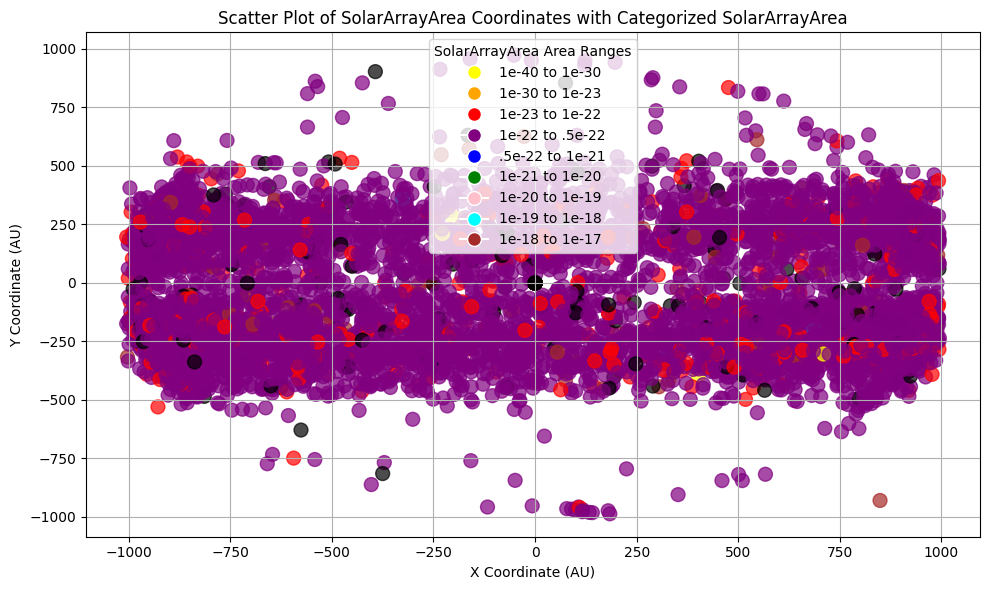

In [84]:
ScatterPlotter("Solar Array",None)
"""As can be seen by the scatter plot, 
the graph was graphed across the globe in a 2d plot, using x and y being a frame of referance. 
The Data depics a large amount of solar array area used to collect energy is within the range of 1e^-23 to .5e^-22. 
This is to be expected because the the solar array is simily picking up small bits of solar particles. """

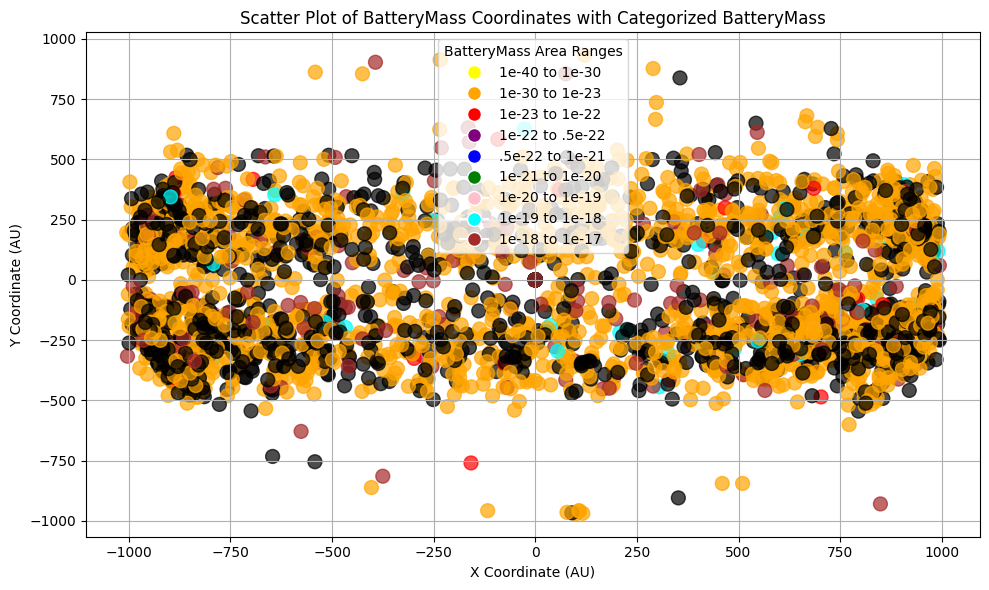

'As can be seen by the scatter plot, the graph was graphed across the globe in a 2d plot, using x and y being a frame of referance. The Data depics a large amount of solar array area used to collect energy is within the range of 1e^-22. This is to be expected because the the solar array is simily picking up small bits of solar particles. The rest of the solar array uses about 1to'

In [85]:
ScatterPlotter("Battery", True)
"""As can be seen by the scatter plot, 
the graph was graphed across the globe in a 2d plot, using x and y being a frame of referance. 
The Data depics a large amount of battery mass used to collect energy is within the range of 1e^-40 to 1e^-22, and then 1e^-20 to 1e^-17. 
This is the tiny amount of battery mass that is being used by the energy of an eclipse per each orbit around the earth. 
The rest of the data is black meaning it is out of rangeof the color bar."""

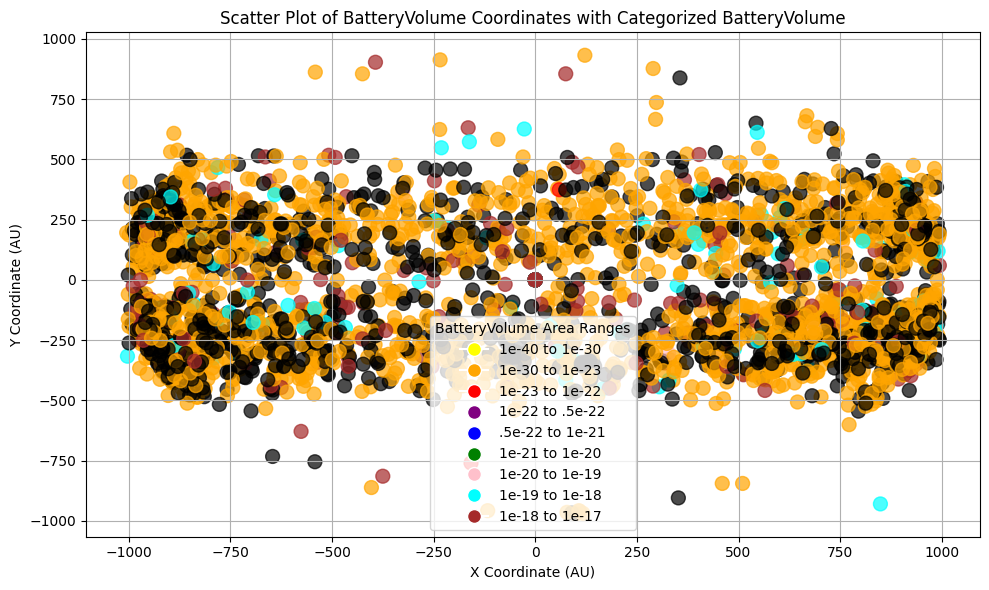

'As can be seen by the scatter plot, \nthe graph was graphed across the globe in a 2d plot, using x and y being a frame of referance. \nThe Data depics a large amount battery volume used to collect energy within the range of \n1e^-40 to 1e^-22 and 1e^-20 to 1e^-17. This is to be expected because the the volume battery \nis simply collecting small bits of solar particles. The rest of the data that is\nblack is simply out of range for the color bar.\n'

In [88]:
ScatterPlotter("Battery", False)
"""As can be seen by the scatter plot, 
the graph was graphed across the globe in a 2d plot, using x and y being a frame of referance. 
The Data depics a large amount battery volume used to collect energy within the range of 
1e^-40 to 1e^-22 and 1e^-20 to 1e^-17. This is to be expected because the the volume battery 
is simply collecting small bits of solar particles. The rest of the data that is
black is simply out of range for the color bar.
"""

Mean Squared Error: 7.395200448131992e-34
Mean Absolute Error: 3.716391072217084e-18
R^2 Score: -1.75432985231541
Cross-Validation R^2 Scores: [-0.77625115  0.03449471 -4.30854512  0.12746436 -0.24066167]
Mean Cross-Validation R^2 Score: -1.032699775455247
Median Cross-Validation R^2 Score: -0.2406616748054935


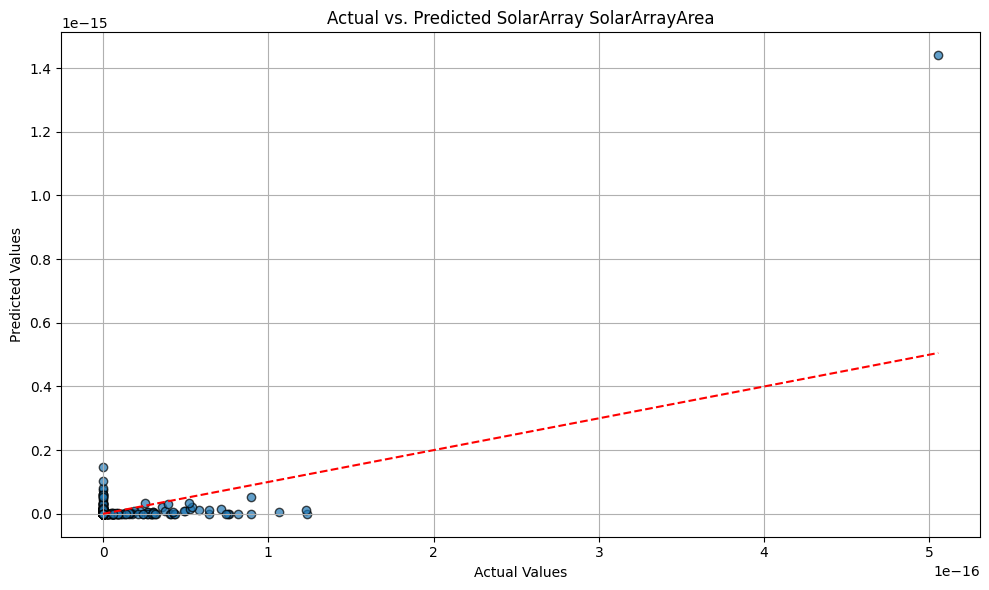

In [97]:

import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
def K_nearest_neighbor_regression(Component, target):
    db_file_path='SunFlareDatabase.db'
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Read data from the database into pandas DataFrames
    Solar_df = pd.read_sql(f'SELECT * FROM {Component}', conn)
    
    # Close the database connection
    conn.close()
    
    
    TakeOutColumns = ['Date', 'id', 'Orbit', 'XCoordinate_AU', 'YCoordinate_AU']  
    
    # Drop unnecessary columns
    X = Solar_df.drop(TakeOutColumns, axis=1)
    y = Solar_df[target]  
    
    # Split the data into training and testing sets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the KNN regressor
    Regressor = KNeighborsRegressor(n_neighbors=5)
    Regressor.fit(trainX, trainY)
    
    # Predict on the test data
    y_pred = Regressor.predict(testX)
    
    # Calculate regression metrics
    mse = mean_squared_error(testY, y_pred)
    mae = mean_absolute_error(testY, y_pred)
    r2 = r2_score(testY, y_pred)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    
    # Use cross-validation to estimate the R^2 score
    cv_scores = cross_val_score(Regressor, X, y, cv=5, scoring='r2')
    
    # Output the list of R^2 scores from cross-validation
    print("Cross-Validation R^2 Scores:", cv_scores)
    
    # Output the mean or median of the cross-validation R^2 scores
    print("Mean Cross-Validation R^2 Score:", cv_scores.mean())
    print("Median Cross-Validation R^2 Score:", np.median(cv_scores))
    
    # Plot Actual vs. Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(testY, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r--')  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted {Component} {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

K_nearest_neighbor_regression("SolarArray", "SolarArrayArea")

Mean Squared Error: 2.0345673208869458e-38
Mean Absolute Error: 1.5137572193448537e-20
R^2 Score: 0.9966321588109763
Cross-Validation R^2 Scores: [0.92662597 0.99892301 0.98468062 0.85287206 0.99571881]
Mean Cross-Validation R^2 Score: 0.9517640922846283
Median Cross-Validation R^2 Score: 0.984680618609717


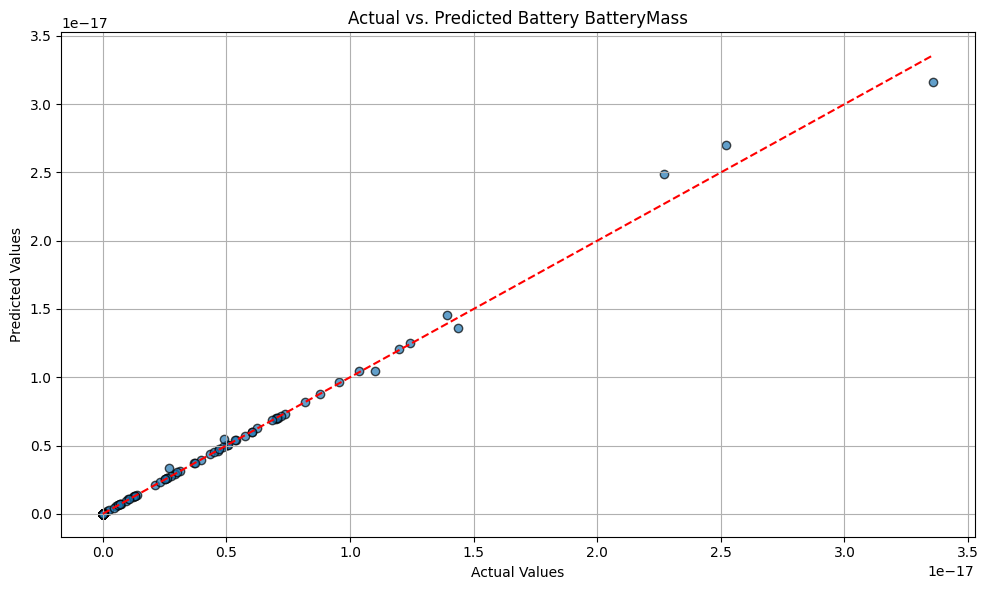

In [102]:
K_nearest_neighbor_regression("Battery", "BatteryMass")


The globe scatter plots of the solar array area, battery mass and battery volume, depict a distrubtion of particles in tiny ranges from 1e^-40 to 1e^-17. The data suggests that the battery mass and volume are vary similar, via just proportionality, interestinlgy that data suggests that there is a focus in energy in a battery from ranges 1e^40 to 1e^22 but skips the range of 1e^22 to 1e^20, when there is a huge focus in solar array area cosumption with that range. Does this really mean anything, no but it is an interesting find.
Afterward I created a kmeans regression plot that predicts the data for the solar array area, the battery mass and volume. Afterward, used cross validation to create a R^2 score. The data suggests that most predicted values will stay within 0.0 to 0.2 of range e^-15, but the actual values show a clear distribution of 0 to 1 of 1*e^-16, showing a larger distribution solar array area used by particles. The battery volume and mass show predicted values from .7 to 0 for 1e^-17, the actual values shows a very different story of a distribution from 0 to 1.5 being by far more scattered, then the predicted outcome. Above is the first attempt at getting the data to have correctly predicted values. Infortunaly as shown by the R^2 values, the model is a bad fit. 

Mean Squared Error: 4.43083549882046e-39
Mean Absolute Error: 7.064200356942649e-21
R^2 Score: 0.9966321588109763
Cross-Validation R^2 Scores: [0.92662597 0.99892301 0.98468062 0.85287206 0.99571881]
Mean Cross-Validation R^2 Score: 0.9517640922846284
Median Cross-Validation R^2 Score: 0.9846806186097171


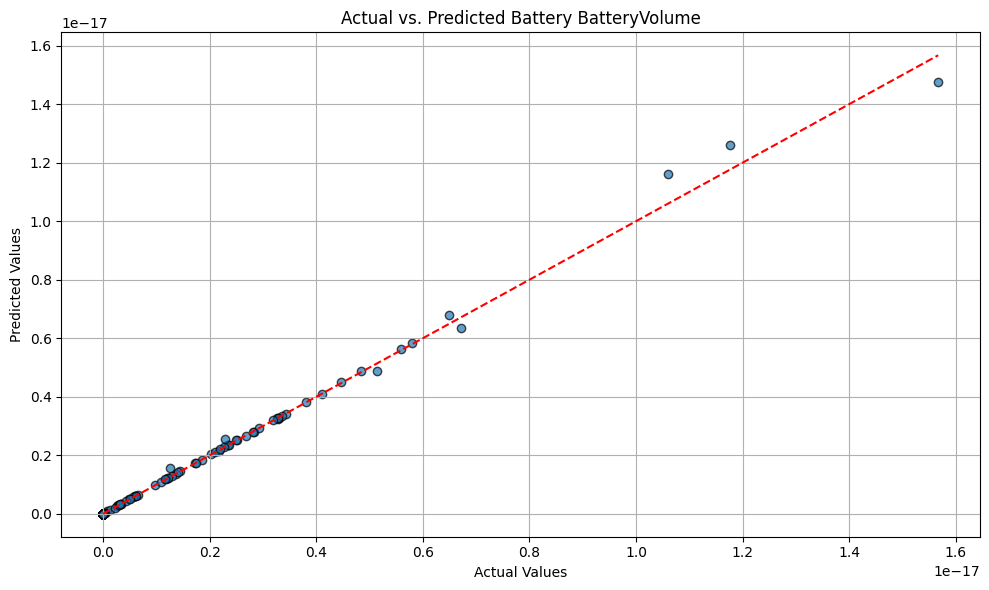

In [101]:
K_nearest_neighbor_regression("Battery", "BatteryVolume")

Mean Squared Error: 8.157685521616522e-36
Mean Absolute Error: 2.6895272006146314e-19
R^2 Score: 0.969616838765114
Cross-Validation R^2 Scores: [0.7204005  0.80827213 0.84697641 0.43099121 0.8662043 ]
Mean Cross-Validation R^2 Score: 0.7345689097389925
Median Cross-Validation R^2 Score: 0.8082721318494098


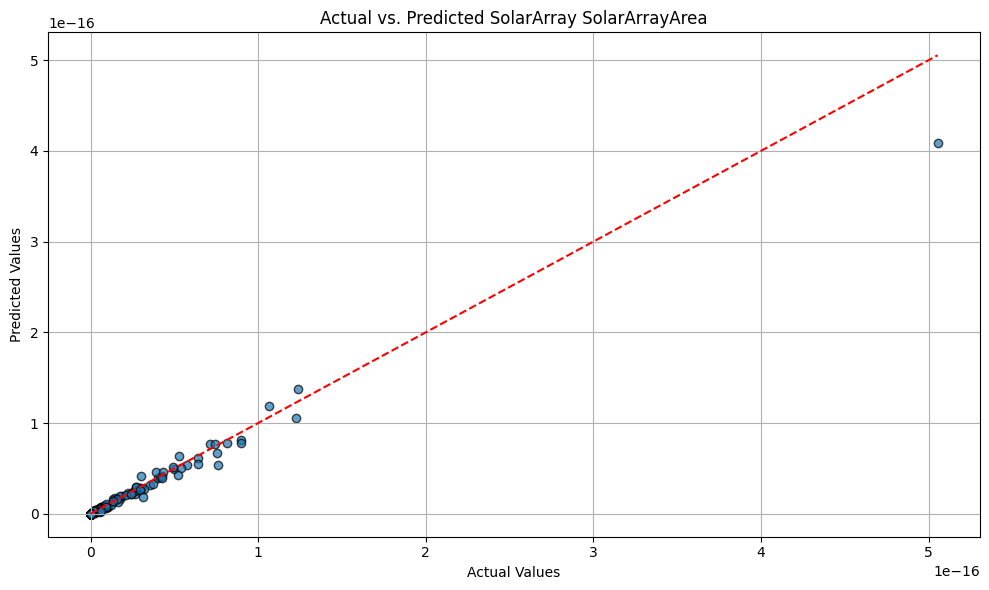

In [98]:
###### K nearest neighbor_regression algirht is used to create predictions on physical properties for electrical components.
###### How the algorithm works is it takes out all columns that are not usable for the calculation classes, and the target phyiscal property.
###### Then the algorithm looks for missing values, and standarizes the data. 
###### Afterwards the data is then split into training and testing x and y.
###### The algorithm then sets up the GridSearchCV with KNearest Neighbor regression.
###### GridsearchCV is used to adjust the parameters, breaks the data into 5 models for cross validation,
###### to create the best fit for KNearest Neighbor regression. 
###### The algorithm then fits the train x and y values to the grid search and KNearest Neighbor regression and 
###### Then creates a prediction on the data, and create validations with the mean squared error, mean absolute error and r^2 score.
###### Additional validation was done on the cv with R^2 score, and R^2 score's median and mean. 
###### Afterwards a plot is done the pridected data, vs the Test Y data. 

import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

def K_nearest_neighbor_regression(Component, target):
    db_file_path = 'SunFlareDatabase.db'
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Read data from the database into pandas DataFrames
    Solar_df = pd.read_sql(f'SELECT * FROM {Component}', conn)
    
    # Close the database connection
    conn.close()
    
    # Assuming 'TakeOutColumns' is a list of columns to be dropped
    TakeOutColumns = ['Date', 'id', 'Orbit', 'XCoordinate_AU', 'YCoordinate_AU']  
    
    # Drop unnecessary columns
    X = Solar_df.drop(TakeOutColumns + [target], axis=1)
    y = Solar_df[target] 
    
    # Handling missing values if any
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    # Standardize the data
    scaler = StandardScaler()  
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and testing sets
    trainX, testX, trainY, testY = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    param_grid = {'n_neighbors': np.arange(1, 30)}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
    grid_search.fit(trainX, trainY)
    
    # Train the KNN regressor with the best parameters
    best_knn = grid_search.best_estimator_
    best_knn.fit(trainX, trainY)
    
    # Predict on the test data
    y_pred = best_knn.predict(testX)
    
    # Calculate regression metrics
    mse = mean_squared_error(testY, y_pred)
    mae = mean_absolute_error(testY, y_pred)
    r2 = r2_score(testY, y_pred)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    
    # Use cross-validation to estimate the R^2 score
    cv_scores = cross_val_score(best_knn, X_scaled, y, cv=5, scoring='r2')
    
    # Output the list of R^2 scores from cross-validation
    print("Cross-Validation R^2 Scores:", cv_scores)
    
    # Output the mean or median of the cross-validation R^2 scores
    print("Mean Cross-Validation R^2 Score:", cv_scores.mean())
    print("Median Cross-Validation R^2 Score:", np.median(cv_scores))
    
    # Plot Actual vs. Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(testY, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted {Component} {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

K_means_regression("SolarArray", "SolarArrayArea")


Mean Squared Error: 2.0345673208869458e-38
Mean Absolute Error: 1.5137572193448537e-20
R^2 Score: 0.9966321588109763
Cross-Validation R^2 Scores: [0.92662597 0.99892301 0.98468062 0.85287206 0.99571881]
Mean Cross-Validation R^2 Score: 0.9517640922846283
Median Cross-Validation R^2 Score: 0.984680618609717


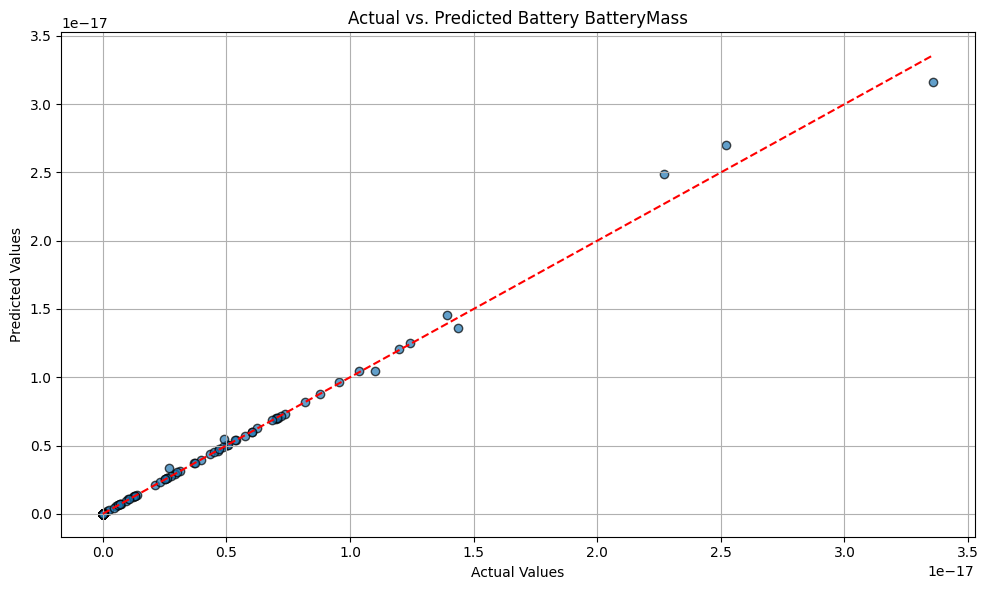

In [99]:
K_nearest_neighbor_regression("Battery", "BatteryMass")

Mean Squared Error: 4.43083549882046e-39
Mean Absolute Error: 7.064200356942649e-21
R^2 Score: 0.9966321588109763
Cross-Validation R^2 Scores: [0.92662597 0.99892301 0.98468062 0.85287206 0.99571881]
Mean Cross-Validation R^2 Score: 0.9517640922846284
Median Cross-Validation R^2 Score: 0.9846806186097171


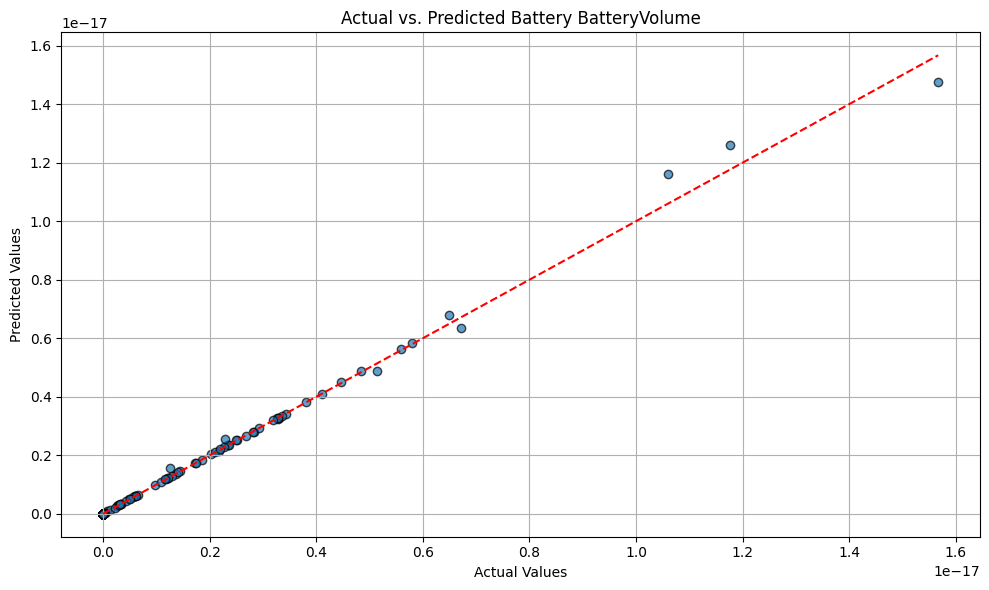

In [100]:
K_nearest_neighbor_regression("Battery", "BatteryVolume")

As shown by the second attempt on changing the model, the predicted values correlate more closely to the acutal values. Both for the solar array area and the volume mass/volume. The solar array area data seems to be more compact in a range from 1 (1e-16)^2, the battery volume/mass have exactly the same data outcome. With a more scattered approach from .6 (1e^-17)^2 with a few outliers. The changes that were needed was handling nan data, using a GridSearchCV, to handle parameters for the model, in order to find the best parameters by using an exhaustive search and then applyigng cross validation, and fit with gridsearch as well. Then train the model with the KNN, using the best fit parameters creating a high score of .95 for R^2 for cross validation mean and .98 R^2 for cross validation median. Over all finding a predictive outcome for how much solar array area and battery volume/mass will be used from solar flares. This data set can predicts the tiny distrubtions or error that solar array energy comsumes, on top of just normal sunlight, and how it may effect and eps system. 